# A quantum-inspired graph kernel for graph classification by SVMs

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

from graph_kernel import (
    dist_from_graph, 
    jensen_shannon, 
    triangular_random_walk, 
    triangular_lattice_draw, 
    kernel_function
)

In https://arxiv.org/abs/2211.16337 the authors demonstrate a graph kernel they call the quantum evolution kernel (QEK) and show that it outperforms other standard graph kernels for some tasks. The idea of the QEK is to initialize a quantum state with a qubit corresponding to each graph node, evolve it with a nearest neighbors interaction, then measure a permutation invariant observable. The distribution of measurement results can then be compared between graphs using a standard kernel between probability distributions. This kernel is meant to be sensitive to global structure in the graph.

We want to explore a similar but entirely classical kernel. We can replace the quantum state evolution replaced by an analogous Clifford circuit. Then the state evolution can be efficiently simulated on a classical computer, giving a classically computed, but "quantum-inspired" kernel.

More precisely, given a graph $G$, both the method of https://arxiv.org/abs/2211.16337 and our method prepare a corresponding probability distribution $p_G(n)$ over the nonnegative integers. We can compare two graphs by comparing their resulting distributions. A typical way to compare two distributions is with the Jensen-Shannon divergence. This leads to a family of graph kernels
$$
K(G_1, G_2) = e^{-\gamma \operatorname{JS}(p_{G_1}, p_{G_2})}
$$
which can be used e.g. in an SVM to classify graphs.

The `graph_kernel.py` module defines a function `dist_from_graph()` that implements a Clifford analog of nearest neighbor interactions on a graph, measures (several times) the ratio of 1s to 0s in the resulting state, and returns the statistics of those measurements as an approximate probability distribution.

We use the networkx package to define and work with graphs. Let's use the `dist_from_graph()` function to get a distribution from a graph:

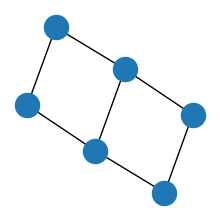

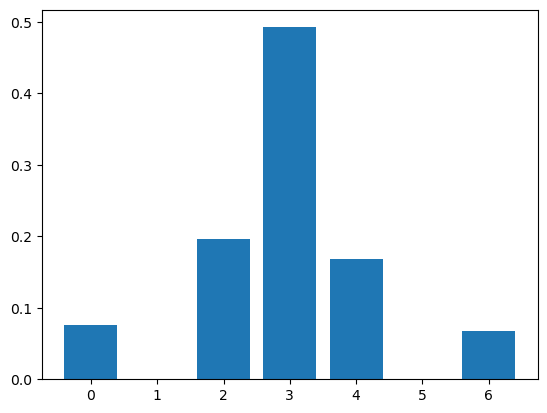

In [2]:
# Make a graph
G = nx.Graph()
G.add_edges_from([(0, 1), (2, 3), (4, 5), (0,2), (3, 5), (1, 3), (2, 4)])

# Draw the graph
fig = plt.figure(figsize=(2, 2))
nx.draw(G)
plt.show()

# Define a probability distribution from the graph
dist = dist_from_graph(G, num_layers=9, shots=1024)

# Plot the distribution
plt.bar(range(G.number_of_nodes() + 1), dist)
plt.show()


Different graphs (potentially) result in different distributions. Let's make two graphs that have different distributions.

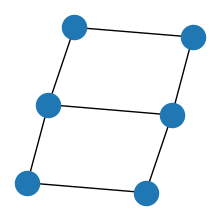

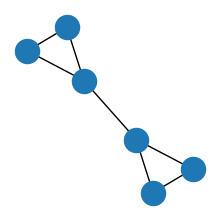

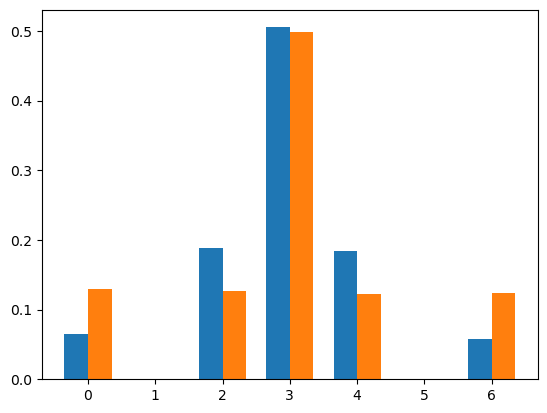

In [3]:
# Make two graphs
G1 = nx.Graph()
G1.add_edges_from([(0, 1), (2, 3), (4, 5), (0,2), (3, 5), (1, 3), (2, 4)])
G2 = nx.Graph()
G2.add_edges_from([(0, 1), (2, 3), (4, 5), (0,2), (3, 5), (1, 2), (3, 4)])

# Draw the graphs
fig = plt.figure(figsize=(2, 2))
nx.draw(G1)
plt.show()
fig = plt.figure(figsize=(2, 2))
nx.draw(G2)
plt.show()

# Define a probability distribution from the graph
dist1 = dist_from_graph(G1, num_layers=9, shots=2**13)
dist2 = dist_from_graph(G2, num_layers=9, shots=2**13)

# Plot the distributions
bar_width = 0.35
x_pos = np.arange(len(dist1))
plt.bar(x_pos, dist1, width=bar_width, label='G1')
plt.bar(x_pos + bar_width, dist2, width=bar_width, label='G2')
plt.xticks(x_pos + bar_width/2, range(len(dist1)))
plt.show()

Note the different distributions for the graphs G1 and G2. Let's define a kernel from this and calculate the kernel element between G1 and G2:

In [4]:
# Define kernel function
def graph_kernel(graph1, graph2, gamma=40):
    dist1 = dist_from_graph(graph1, num_layers=9, shots=2**13)
    dist2 = dist_from_graph(graph2, num_layers=9, shots=2**13)
    return np.exp(-gamma*jensen_shannon(dist1, dist2))

# Calculate kernel between G1 and G2
graph_kernel(G1, G2)

0.5040814226292281

## Synthetic data

The authors of https://arxiv.org/abs/2211.16337 test the QEK on a classification task with synthetic data (see section III.F on page 8). We can test our classically computed method the same way. Their data consist  of graphs made from random walks on a triangular lattice. Within the triangular lattice is a "preferred" sublattice that the random walk will preferentially go to. There are two choices for this preferred sublattice, a hexagonal sublattice and a kagome sublattice. They generate 100 random walks with the preferred hexagonal sublattice and 100 with the preferred kagome sublattice. The classification task is to distinguish between graphs prepared with the hexagonal sublattice and graphs prepared with the kagome sublattice.

The `graph_kernel.py` module contains a function `triangular_random_walk()`, which creates graphs in this way. Let's recreate a dataset as described in https://arxiv.org/abs/2211.16337:

In [5]:
N = 200 # Total number of graphs
num_nodes = 20 # Number of nodes in each graph

p = 0.0 # Probability of accepting a non-preferred vertex to the random walk

graph_list = []
y = np.zeros(N)
for i in range(N//2):
    graph = triangular_random_walk(num_nodes, p, sublattice='honeycomb')
    graph_list.append(graph)
    y[i] = 1
for i in range(N//2, N):
    graph = triangular_random_walk(num_nodes, p, sublattice='kagome')
    graph_list.append(graph)
    y[i] = 0

We've made `graph_list`, a list of 200 networkx graphs. Let's visualize some of them. This can be nicely done with our function `triangular_lattice_draw()`:

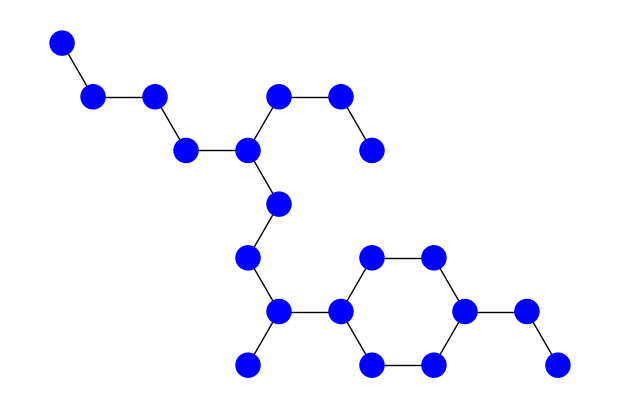

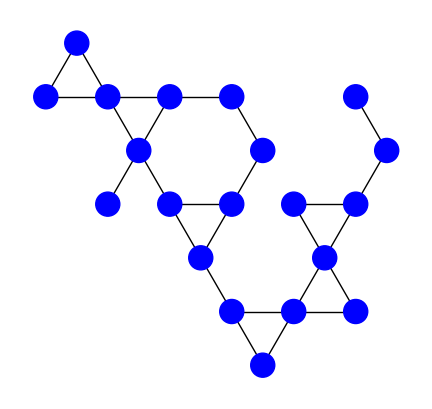

In [6]:
# Visualize a graph from the hexagonal sublattice
triangular_lattice_draw(graph_list[42])

# Visualize a graph from the kagome sublattice
triangular_lattice_draw(graph_list[142])

Let's now use `dist_from_graph()` to change our 200 graphs into probability distributions. We'll then split the resulting datapoints into testing and training sets.

In [7]:
X = np.zeros((N, num_nodes + 1))
for i, graph in enumerate(graph_list):
    X[i] = dist_from_graph(graph, num_layers=9, shots=1024)
    print(f'Prepared distribution from graph {i + 1}/{N}', end='\r')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## SVM

Let's try to classify the distributions in `X` using an SVM. The function `kernel_function()` in `graph_kernel.py` is a custom kernel using the Jensen-Shannon divergence. We will use this kernel to make an SVM using the sklearn package svm module:

In [8]:
# Make SVM from our kernel function
graph_svm = svm.SVC(kernel=kernel_function)


# Train it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
graph_svm.fit(X_train, y_train)

# Test it
y_predicted = graph_svm.predict(X_test)
accuracy = np.mean(y_predicted == y_test)
print(accuracy)

0.65


Better than chance, but clearly we can do better. We can optimize the circuit used to generate the distributions form graphs. We can do this using the `num_layers` keyword argument of `dist_from_graph()` or, for more control, the `discrete_parameters` keyword argument. In addition to changing the circuit, we can of course also change the regularization parameter $C$ of the SVM or the coefficient `gamma` in the exponent of our kernel function.

There are many optimizations to try. Can we iteratively improve this to get near-perfect classification? One obstacle compared to the QEK is that unlike for a quantum circuit or interaction there are no continuous parameters to vary in the Clifford circuit defining our kernel. There are instead various discrete parameters. To get a useful model we must optimize those. The plan is to fill this repo with experiments along these lines as well as other tests of this Clifford evolution kernel.

## Identifying circuits that lead to useful kernels

We will first search for circuits that lead to good kernels either on their own or in combination. Then we will optimize over hyperparameters like `C` and `gamma`. First let's search over the circuit used to define the kernel. We can control some details of the circuit performed by `dist_from_graph()` using the `discrete_parameters` keyword argument. This argument is a numpy array where each row represents a layer of the circuit. Each row has 4 entries that are either 0 or 1 and determine if a particular set of gates is implemented or not in the circuit. Different choices lead to different measurement statistics and hence different feature maps. For example, the following performs a particular circuit with 2 layers:

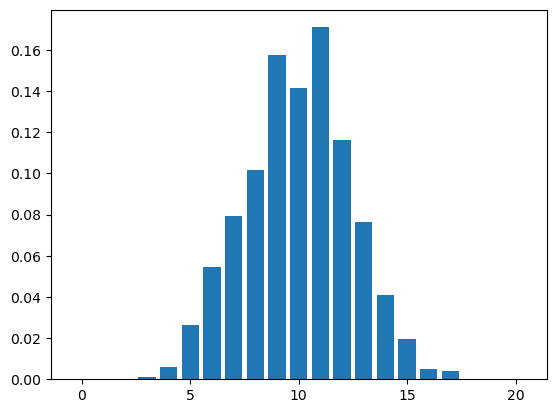

In [9]:
# Parameters deciding which gates sets will be included in each of two layers
discrete_parameters = np.array(
    [[0, 1, 1, 0],
     [0, 1, 0, 0]]
)

# The resulting distribution
dist = dist_from_graph(graph_list[42], discrete_parameters, shots=1024)

plt.bar(range(num_nodes + 1), dist)
plt.show()

Play around with different choices for `discrete_parameters` and see how the resulting distribution changes. We can build an SVM out of any such choice of parameters. For example, for the choice above we have:

In [10]:
# Get distributions using the above parameters
X = np.zeros((N, num_nodes + 1))
for i, graph in enumerate(graph_list):
    X[i] = dist_from_graph(graph, discrete_parameters, shots=1024)
    print(f'Prepared distribution from graph {i + 1}/{N}', end='\r')
print('\n')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# SVM with the new data
graph_svm = svm.SVC(kernel=kernel_function)
graph_svm.fit(X_train, y_train)
y_predicted = graph_svm.predict(X_test)
accuracy = np.mean(y_predicted == y_test)
print(f'Accuracy: {accuracy}')

Prepared distribution from graph 200/200

Accuracy: 0.55


Let's do a search over different choices of circuit. We'll start with all possible 1-layer circuits. (This may take a few minutes. See the precomputed data saved as `X_1_layer.pkl`):

Prepared distribution from graph 200/200 using parameters [1, 1, 1, 1]                              



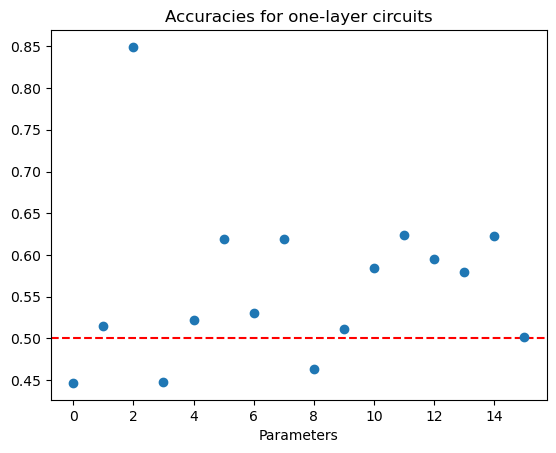

In [12]:
# Prepare data
X_1_layer = np.zeros((2**4, N, num_nodes + 1))
for j, ind in enumerate(np.ndindex((2, 2, 2, 2))):
    discrete_parameters = np.array([list(ind)])
    X = np.zeros((N, num_nodes + 1))
    for i, graph in enumerate(graph_list):
        X[i] = dist_from_graph(graph, discrete_parameters, shots=1024)
        print(f'Prepared distribution from graph {i + 1}/{N} using parameters '
              f'{list(ind)}' + ' '*30, end='\r')
    X_1_layer[j] = X
print('\n')

# Test performance
repetitions = 100
accuracies_1_layer = []
for i in range(2**4):
    X = X_1_layer[i].copy()
    
    mean_accuracy = 0
    for _ in range(repetitions):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        graph_svm = svm.SVC(kernel=kernel_function, C=10)
        graph_svm.fit(X_train, y_train)
        y_predicted = graph_svm.predict(X_test)
        accuracy = np.mean(y_predicted == y_test)
        mean_accuracy += accuracy
    mean_accuracy /= repetitions

    accuracies_1_layer.append(mean_accuracy)
    print(f'Tested circuit {i + 1}/16', end='\r')

# Plot the results
plt.axhline(y=0.5, color='r', linestyle='--')
plt.plot(accuracies_1_layer, 'o')
plt.title('Accuracies for one-layer circuits')
plt.xlabel('Parameters')
plt.show()

We see that the circuit with parameters `[[0, 0, 1, 0]]` gives higher accuracy. Other experiments identify `[[0, 1, 0, 1], [0, 0, 0, 1]]` and `[[1, 0, 1, 0], [1, 0, 0, 0], [1, 1, 1, 0]]` among many others as parameters that give good kernels. (See the precomputed data saved as `X_2_layer.pkl` and `X_3_layer.pkl`.) Each on its own gives a classifier that performs distinctly better than chance, but with less than 90% accuracy. We can do better by combining several such kernels.